# Logistic Regression Optimisation in High Dimensions

This project investigates the optimisation of logistic regression models in high-dimensional feature spaces, comparing the performance of **Majorisation–Minimisation (MM)** against traditional methods,  **Gradient Descent (GD)** and **Newton-Raphson (NR)**, while incorporating optional regularisation.

<br>

---

<br>

### How to Use This Notebook

- Run in Google Colab
- Mount Google Drive when prompted (required to load and save project files)
- Ensure `INPUT_PATH` and `OUTPUT_PATH` are updated
- Set `VERBOSE = True` to enable progress logging
- Adjust experiment parameters in **Implementation** > **Settings & Configurations**

<br>


## Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import time
import signal
import re

In [ ]:
np.random.seed(9)

In [ ]:
# Update these paths
INPUT_PATH = '/content/drive/My Drive/Capstone Project/Code Inputs'
OUTPUT_PATH = '/content/drive/My Drive/Capstone Project/Code Outputs'

In [ ]:
VERBOSE = True  # Toggle to enable/disable log output

def log(msg):
    if VERBOSE:
        print(f"[LOG] {msg}")

## Data Loading and Preparation

### Loan Data

The real-world dataset used in this project is sourced from the [Lending Club Loan Data](https://www.kaggle.com/datasets/wordsforthewise/lending-club) available on Kaggle.

Preprocessing was carried out externally and includes:
- Dropping irrelevant or high-cardinality categorical columns
- Handling missing values
- Encoding categorical features
- Feature scaling
- Train-test splitting with class balance

*Note: The preprocessing pipeline was adapted from existing public notebooks, with  modifications made to suit the goals of this project.*

In [ ]:
data = np.load(f'{INPUT_PATH}/loan-data-preprocessed.npz', allow_pickle=True)

feature_names = data['feature_names'].tolist()
X1_train = data['X_train']
y1_train = data['y_train']
X1_test = data['X_test']
y1_test = data['y_test']

feature_names = ['Intercept'] + feature_names
X1_train = np.hstack([np.ones((X1_train.shape[0], 1)), X1_train])
X1_test = np.hstack([np.ones((X1_test.shape[0], 1)), X1_test])

log(f"Loan data loaded. X_train shape: {X1_train.shape}, y_train shape: {y1_train.shape}")

[LOG] Loan data loaded. X_train shape: (63744, 78), y_train shape: (63744,)


### Synthetic Data Generator

In [ ]:
def gen_data(samples, features, seed=None):
    if seed is not None:
        np.random.seed(seed)

    total = int(np.ceil(samples * 1.25)) # Fixed 20% test set

    theta_true = np.random.rand(features + 1)
    X = np.random.normal(0, 3, (total, features))
    X_with_intercept = np.hstack([np.ones((total, 1)), X])

    y_prob = sigmoid(X_with_intercept @ theta_true)
    y = np.random.binomial(1, y_prob) # Simulate binary labels

    noise = 0.2 * np.random.randn(total, features)
    X_noisy = X + noise
    X_noisy_with_intercept = np.hstack([np.ones((total, 1)), X_noisy])

    X_train, X_test, y_train, y_test = train_test_split(X_noisy_with_intercept, y, train_size=samples, random_state=9)

    log(f"Synthetic data generated. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

    return X_train, y_train, X_test, y_test, theta_true

## Optimisation Algorithms

### Support Functions


In [ ]:
def sigmoid(z):
    z = np.clip(z, -500, 500)  # Prevent overflow
    return 1 / (1 + np.exp(-z))

def objective(X, y, theta, reg_type='None', reg_lambda=1):
    p = sigmoid(X @ theta)
    p = np.clip(p, 1e-10, 1 - 1e-10) # Prevent log(0)
    obj = -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p)) # Negative log likelihood

    if reg_type == 'L2':
        obj += (reg_lambda / 2) * np.sum(theta[1:] ** 2)
    elif reg_type == 'L1':
        obj += reg_lambda * np.sum(np.abs(theta[1:]))
    elif reg_type == 'EN':
        l1_term = en_alpha * np.sum(np.abs(theta[1:]))
        l2_term = (1 - en_alpha) * np.sum(theta[1:] ** 2)
        obj += reg_lambda * (l1_term + l2_term / 2)

    return obj

def gradient(X, y, theta, reg_type='None', reg_lambda=1):
    p = sigmoid(X @ theta)
    grad = -X.T @ (y - p)

    if reg_type == 'L2':
        grad[1:] += reg_lambda * theta[1:]
    elif reg_type == 'L1':
        grad[1:] += reg_lambda * np.sign(theta[1:]) # Subgradient with single value at 0
    elif reg_type == 'EN':
         grad[1:] += reg_lambda * (en_alpha * np.sign(theta[1:]) + (1 - en_alpha) * theta[1:])

    return grad

def hessian(X, theta, reg_type='None', reg_lambda=1):
    p = sigmoid(X @ theta)
    W = np.diag(p * (1 - p))
    H = X.T @ W @ X + 1e-6 * np.eye(X.shape[1]) # Prevent singular matrix

    if reg_type == 'L2':
        H += reg_lambda * np.eye(X.shape[1])
        H[0, 0] -= reg_lambda
    if reg_type == 'L1':
        print("Warning: Hessian for L1 is undefined. Ignoring regularisation.")
    if reg_type == 'EN':
        print("Warning: Hessian for EN is undefined. Ignoring regularisation.")

    return H

### Optimisers


In [ ]:
def majorization_minimization(X, y, reg_type='None', reg_lambda=1, tol=1e-2):
    obj_history = []
    theta = np.random.normal(0, 0.01, X.shape[1])

    M = 0.25 * (X.T @ X) + 1e-6 * np.eye(X.shape[1])  # Upper bound of Hessian for MM surrogate

    if reg_type == 'L2':
        M += reg_lambda * np.eye(X.shape[1])
        M[0, 0] -= reg_lambda
    elif reg_type == 'L1':
        pass
    elif reg_type == 'EN':
        M += reg_lambda * (1 - en_alpha) * np.eye(X.shape[1])
        M[0, 0] -= reg_lambda * (1 - en_alpha)

    M_inv = np.linalg.inv(M)

    iteration = 1
    while True:
        obj = objective(X, y, theta, reg_type, reg_lambda)
        obj_history.append(obj)

        grad = gradient(X, y, theta, reg_type, reg_lambda)
        theta_new = theta - M_inv @ grad

        if np.linalg.norm(theta_new - theta) < tol:
            return iteration, theta_new, obj_history

        theta = theta_new
        iteration += 1

In [ ]:
def gradient_descent(X, y, reg_type='None', reg_lambda=1, tol=1e-2):
    obj_history = []
    theta = np.random.normal(0, 0.01, X.shape[1])

    iteration = 1
    while True:
        obj = objective(X, y, theta, reg_type, reg_lambda)
        obj_history.append(obj)

        grad = gradient(X, y, theta, reg_type, reg_lambda)
        grad_norm_sq = np.linalg.norm(grad) ** 2  # For descent check

        # Backtracking line search to adapt step size
        step = 1.0
        while True:
            theta_temp = theta - step * grad
            obj_temp = objective(X, y, theta_temp, reg_type, reg_lambda)

            if obj_temp <= obj - gd_alpha * step * grad_norm_sq: # Enforce sufficient decrease
                break
            step *= gd_beta  # Shrink step size

        theta_new = theta - step * grad

        if np.linalg.norm(theta_new - theta) < tol:
            return iteration, theta_new, obj_history

        theta = theta_new
        iteration += 1

In [ ]:
def newton_raphson(X, y, reg_type='None', reg_lambda=1, tol=1e-2):
    obj_history = []
    theta = np.random.normal(0, 0.01, X.shape[1])

    iteration = 1
    while True:
        obj = objective(X, y, theta, reg_type, reg_lambda)
        obj_history.append(obj)

        grad = gradient(X, y, theta, reg_type, reg_lambda)
        H = hessian(X, theta, reg_type, reg_lambda)
        theta_new = theta - np.linalg.solve(H, grad) # More efficient inverse

        if np.linalg.norm(theta_new - theta) < tol:
            return iteration, theta_new, obj_history

        theta = theta_new
        iteration += 1

## Implementation


### Settings & Configurations


In [ ]:
num_trials = 10         # Trials per configuration
tim_lim = 600           # Timeout limit per trial (s)

en_alpha = 0.5          # Balance between L1 & L2
gd_alpha = 0.3          # Backtracking threshold
gd_beta = 0.5           # Backtracking shrink


include_loan_data = True
dims = [ # Synthetic datasets
    (500, 10), (500, 100), (500, 1000),
    (1000, 10), (1000, 100),(1000, 1000),
    (2000, 10), (2000, 100), (2000, 1000),
    (10000, 5000)

    # (500, 10), (1000, 100), (2000, 1000)
]


optimisers = {
    'Majorization-Minimization': majorization_minimization
    ,'Gradient Descent': gradient_descent
    ,'Newton-Raphson': newton_raphson
}


reg_types = [
    'None'
    ,'L1'
    ,'L2'
    ,'EN'
    ]
reg_lambda = 100


tols = [
    1e-2
    # ,1e-3
    # ,1e-6
    ]

### Support Functions

In [ ]:
# Raise custom exception if trial exceeds time limit
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

signal.signal(signal.SIGALRM, timeout_handler)

<Handlers.SIG_DFL: 0>

In [ ]:
def run_trial(X_train, y_train, X_test, y_test, optimiser, reg_type, reg_lambda, tol):
    start_time = time.perf_counter()
    iters, theta, objs = optimiser(X_train, y_train, reg_type, reg_lambda, tol)
    duration = time.perf_counter() - start_time

    p = sigmoid(X_test @ theta)
    preds = (p >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds)

    return duration, iters, theta, objs, acc

In [ ]:
def run_all_experiments(datasets, optimisers, reg_types, reg_lambda, tols, num_trials, tim_lim):
    main_results = []
    obj_history = []
    best_loan_model = {'Optimiser': None, 'Reg': None, 'Tol': None, 'Theta': None, 'Accuracy': -1}
    other_params = {'Reg_Strength': reg_lambda, 'Num_Trials': num_trials, 'Timeout_Limit': tim_lim}
    order = 1

    for dataset_name, (X_train, y_train, X_test, y_test) in datasets.items():
        for optimiser_name, optimiser in optimisers.items():
            for reg_type in reg_types:
                for tol in tols:
                    if optimiser_name == 'Newton-Raphson' and reg_type in ['L1', 'EN']:
                        continue # Skip unsupported regularisation types for NR

                    summary = {
                        'Order': order,
                        'Dataset': dataset_name,
                        'Optimiser': optimiser_name,
                        'Reg': reg_type,
                        'Tol': tol
                    }

                    duration_list, iters_list, theta_list, objs_list, acc_list = [], [], [], [], []
                    all_trials_completed = True

                    for trial in range(num_trials):
                        try:
                            signal.alarm(tim_lim)
                            log(f"Running: {dataset_name:<32} | {optimiser_name:<25} | Reg={reg_type:<5} | Tol={tol:<6} | Trial={trial+1}")
                            duration, iters, theta, objs, acc = run_trial(X_train, y_train, X_test, y_test, optimiser, reg_type, reg_lambda, tol)

                            duration_list.append(duration)
                            iters_list.append(iters)
                            theta_list.append(theta)
                            objs_list.append(objs)
                            acc_list.append(acc)

                        except TimeoutException:
                            log("[TIMEOUT] Skipping configuration")
                            all_trials_completed = False
                            break

                        finally:
                            signal.alarm(0)

                    if all_trials_completed:
                        summary.update({
                            'Avg_Time': np.mean(duration_list),
                            'Std_Time': np.std(duration_list),
                            'Avg_Iters': np.mean(iters_list),
                            'Std_Iters': np.std(iters_list),
                            'Avg_Accuracy': np.mean(acc_list),
                            'Std_Accuracy': np.std(acc_list),
                        })

                        # Objective history of median final value
                        median_obj = sorted(objs_list, key=lambda h: h[-1])[len(objs_list) // 2]
                        for i, val in enumerate(median_obj):
                            obj_history.append({
                                'Order': order,
                                'Dataset': dataset_name,
                                'Optimiser': optimiser_name,
                                'Reg': reg_type,
                                'Tol': tol,
                                'Iteration': i + 1,
                                'Objective': val
                            })

                        if 'Loan Data' in dataset_name:
                            best_idx = np.argmax(acc_list)
                            best_acc = acc_list[best_idx]

                            if best_acc > best_loan_model['Accuracy']:
                                best_loan_model.update({
                                    'Optimiser': optimiser_name,
                                    'Reg': reg_type,
                                    'Tol': tol,
                                    'Theta': theta_list[best_idx],
                                    'Accuracy': best_acc
                                })

                    else: # Timeout
                        summary.update({
                            'Avg_Time': None,
                            'Std_Time': None,
                            'Avg_Iters': None,
                            'Std_Iters': None,
                            'Avg_Accuracy': None,
                            'Std_Accuracy': None,
                        })

                    main_results.append(summary)
                    order += 1

    log("Completed.")
    return main_results, obj_history, best_loan_model, other_params

### Execution


In [ ]:
execute = True

if execute:
    datasets = {}
    if include_loan_data:
        datasets[f'Loan Data (n={X1_train.shape[0]}, p={X1_train.shape[1]})'] = (X1_train, y1_train, X1_test, y1_test)
    for n, p in dims:
        X_train, y_train, X_test, y_test, _ = gen_data(n, p)
        datasets[f'Synthetic Data (n={n}, p={p})'] = (X_train, y_train, X_test, y_test)

    main_results, obj_history, best_loan_model, other_params = run_all_experiments(datasets, optimisers, reg_types, reg_lambda, tols, num_trials, tim_lim)

    main_results_df = pd.DataFrame(main_results)
    obj_history_df = pd.DataFrame(obj_history)
    other_params_df = pd.DataFrame([other_params])

    if best_loan_model['Theta'] is not None:
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Theta': best_loan_model['Theta'],
            'Importance': np.abs(best_loan_model['Theta'])
        }).sort_values(by='Importance', ascending=False)

In [ ]:
save_file_as = None #'results'

if save_file_as is not None:
    with pd.ExcelWriter(f"{OUTPUT_PATH}/{save_file_as}.xlsx") as writer:
        main_results_df.to_excel(writer, sheet_name='Main Results', index=False)
        obj_history_df.to_excel(writer, sheet_name='Objective History', index=False)
        other_params_df.to_excel(writer, sheet_name='Other Parameters', index=False)

        if best_loan_model['Theta'] is not None:
            feature_importance_df.to_excel(writer, sheet_name='Loan Feature Importance', index=False)

    log("Results saved")

In [ ]:
load_file = None #'results-main'

if load_file is not None:
    with pd.ExcelFile(f"{OUTPUT_PATH}/{load_file}.xlsx") as xls:
        main_results_df = pd.read_excel(xls, sheet_name='Main Results')
        obj_history_df = pd.read_excel(xls, sheet_name='Objective History')
        other_params_df = pd.read_excel(xls, sheet_name='Other Parameters')

        try:
            feature_importance_df = pd.read_excel(xls, sheet_name='Loan Feature Importance')
        except ValueError:
            pass

    main_results_df['Reg'] = main_results_df['Reg'].fillna('None') # Fix loading issue with reg_type='None'
    obj_history_df['Reg'] = obj_history_df['Reg'].fillna('None')

    log("Results loaded")

[LOG] Results loaded


## Analysis

### Settings


In [ ]:
title_font = 15
subtitle_font = 10

optimiser_labels = {
    'Majorization-Minimization': 'MM',
    'Gradient Descent': 'GD',
    'Newton-Raphson': 'NR'
}

metric_labels = {
    'Avg_Time': 'Runtime (s)',
    'Avg_Iters': 'Iterations'
}

main_colour = '#0569b9'

optimiser_colours = {
    'Majorization-Minimization': '#0569b9',
    'Gradient Descent': '#b90569',
    'Newton-Raphson': '#69b905'
}

op_colours = {
        optimiser_labels[opt]: optimiser_colours[opt]
        for opt in optimisers if opt in optimiser_labels
    }

default_palette = [
    '#1b9e77',  # teal green
    '#d95f02',  # burnt orange
    '#7570b3',  # muted purple
    '#5c4b51',  # warm charcoal
    '#66a61e',  # olive green
    '#e6ab02',  # mustard yellow
    '#a6761d',  # brown
    '#666666',  # neutral grey
    '#8dd3c7',  # aqua blue
    '#b3a2c8',  # soft lavender
    '#80b1d3',  # soft sky blue
    '#c9b37e'   # desaturated tan
]

### Support Functions

In [ ]:
def plot_iters_rpi_time_bar(df, dataset_name, optimisers, reg_types, save_plot_as):
    df_plot = df[
        (df['Dataset'] == dataset_name) &
        (df['Optimiser'].isin(optimisers)) &
        (df['Reg'].isin(reg_types))
    ].copy()

    df_plot['OptimiserShort'] = df_plot['Optimiser'].map(optimiser_labels)
    df_plot['TimePerIter'] = df_plot['Avg_Time'] / df_plot['Avg_Iters'] * 1000
    df_plot['TotalTime'] = df_plot['Avg_Time']

    fig, axes = plt.subplots(1, 3, figsize=(17, 4.5), sharey=False)

    # Plot 1
    sns.barplot(
        data=df_plot,
        x='Reg',
        y='Avg_Iters',
        hue='OptimiserShort',
        palette=op_colours,
        ax=axes[0]
    )
    axes[0].set_title("Iterations to Convergence", fontsize=title_font)
    axes[0].set_ylabel("Iterations", fontsize=subtitle_font)
    axes[0].set_xlabel("Regularisation", fontsize=subtitle_font)
    axes[0].tick_params(labelsize=subtitle_font)
    axes[0].legend(title=None, fontsize=subtitle_font)

    for container in axes[0].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                axes[0].annotate(f"{int(round(height))}",
                                 xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, 3), textcoords="offset points",
                                 ha='center', va='bottom', fontsize=subtitle_font - 2)

    # Plot 2
    sns.barplot(
        data=df_plot,
        x='Reg',
        y='TimePerIter',
        hue='OptimiserShort',
        palette=op_colours,
        ax=axes[1]
    )
    axes[1].set_title("Runtime per Iteration (RPI)", fontsize=title_font)
    axes[1].set_ylabel("Runtime (ms)", fontsize=subtitle_font)
    axes[1].set_xlabel("Regularisation", fontsize=subtitle_font)
    axes[1].tick_params(labelsize=subtitle_font)
    axes[1].legend(title=None, fontsize=subtitle_font)

    for container in axes[1].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                axes[1].annotate(f"{int(round(height))}",
                                 xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, 3), textcoords="offset points",
                                 ha='center', va='bottom', fontsize=subtitle_font - 2)

    # Plot 3
    sns.barplot(
        data=df_plot,
        x='Reg',
        y='TotalTime',
        hue='OptimiserShort',
        palette=op_colours,
        ax=axes[2]
    )
    axes[2].set_title("Total Runtime", fontsize=title_font)
    axes[2].set_ylabel("Runtime (s)", fontsize=subtitle_font)
    axes[2].set_xlabel("Regularisation", fontsize=subtitle_font)
    axes[2].tick_params(labelsize=subtitle_font)
    axes[2].legend(title=None, fontsize=subtitle_font)

    for container in axes[2].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                axes[2].annotate(f"{height:.1f}",
                                 xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, 3), textcoords="offset points",
                                 ha='center', va='bottom', fontsize=subtitle_font - 2)

    plt.tight_layout()

    if save_plot_as is not None:
        plt.savefig(f"{OUTPUT_PATH}/{save_plot_as}.png", dpi=300)

    plt.show()
    plt.close(fig)

In [ ]:
def plot_change_iters_and_rpi_bar(data, save_plot_as):
    with pd.ExcelFile(f"{OUTPUT_PATH}/results-tol-{data}.xlsx") as xls:
        df = pd.read_excel(xls, sheet_name='Main Results')
        df['Reg'] = df['Reg'].fillna('None')

    df['TimePerIter'] = df['Avg_Time'] / df['Avg_Iters'] * 1000
    regs = pd.unique(df['Reg'].dropna())
    opts = pd.unique(df['Optimiser'].dropna())
    datasets = pd.unique(df['Dataset'].dropna())

    fig, axes = plt.subplots(len(datasets), 2, figsize=(11, 4.5 * len(datasets)), sharey=False)
    if len(datasets) == 1:
        axes = [axes]

    for row_idx, dataset in enumerate(datasets):
        df_ds = df[df['Dataset'] == dataset]

        for col_idx, metric in enumerate(['Avg_Iters', 'TimePerIter']):
            bar_data = []

            for reg in regs:
                for opt in opts:
                    sub = df_ds[(df_ds['Reg'] == reg) & (df_ds['Optimiser'] == opt) & df_ds['Tol'].isin([1e-2, 1e-3])]
                    grouped = sub.groupby('Tol')[metric].mean()

                    if 1e-2 in grouped and 1e-3 in grouped:
                        base, new = grouped[1e-2], grouped[1e-3]
                        pct = 100 * (new - base) / base if base != 0 else np.nan
                        delta = new - base
                    else:
                        pct, delta = np.nan, None

                    bar_data.append({
                        'Reg': reg,
                        'Opt': optimiser_labels.get(opt, opt),
                        'Pct': pct,
                        'Delta': delta
                    })

            plot_df = pd.DataFrame(bar_data)
            ax = axes[row_idx][col_idx]

            sns.barplot(
                data=plot_df,
                x='Reg',
                y='Pct',
                hue='Opt',
                palette=op_colours,
                dodge=True,
                ax=ax
            )

            for bars, opt in zip(ax.containers, plot_df['Opt'].unique()):
                opt_data = plot_df[plot_df['Opt'] == opt]
                for bar, (_, row) in zip(bars, opt_data.iterrows()):
                    if pd.notna(row['Delta']):
                        ax.annotate(f"({round(row['Delta']):+})",
                                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                    xytext=(0, 3), textcoords="offset points",
                                    ha='center', va='bottom',
                                    fontsize=subtitle_font - 2)

            title = "Change in Iterations" if metric == 'Avg_Iters' else "Change in RPI"
            ax.set_title(title, fontsize=title_font)
            ax.set_ylabel("% Change", fontsize=subtitle_font)
            ax.set_xlabel("Regularisation", fontsize=subtitle_font)
            ax.tick_params(labelsize=subtitle_font)
            ax.legend(title=None, fontsize=subtitle_font)

            if col_idx == 0:
                ax.set_ylabel(f"{dataset}\n\n% Change", fontsize=subtitle_font)

    plt.tight_layout()

    if save_plot_as:
        plt.savefig(f"{OUTPUT_PATH}/{save_plot_as}.png", dpi=300)

    plt.show()
    plt.close(fig)

### Results Analysis (Loan)

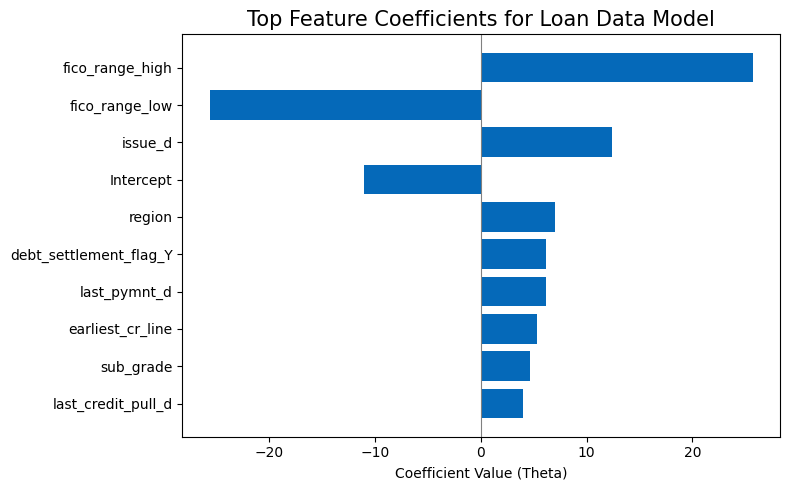

In [ ]:
save_plot1_as = None #'feat-coeff'

def plot_feature_coeff_bar(feature_importance_df, save_plot_as, top_n=10):
    top_features = feature_importance_df.head(top_n)
    features = top_features['Feature']
    thetas = top_features['Theta']

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.barh(features, thetas, color=main_colour)
    ax.axvline(0, color='gray', linewidth=0.8)
    ax.set_title("Top Feature Coefficients for Loan Data Model", fontsize=title_font)
    ax.set_xlabel("Coefficient Value (Theta)", fontsize=subtitle_font)
    ax.tick_params(labelsize=subtitle_font)
    ax.invert_yaxis()
    plt.tight_layout()

    if save_plot_as is not None:
        plt.savefig(f"{OUTPUT_PATH}/{save_plot_as}.png", dpi=300)

    plt.show()
    plt.close(fig)
plot_feature_coeff_bar(feature_importance_df, save_plot1_as)

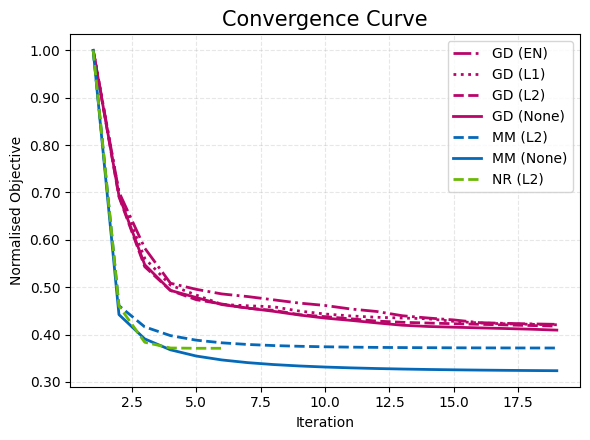

In [ ]:
save_plot2_as = None #'conv-curve'

def plot_conv_curve(obj_df, dataset_name, save_plot_as):
    df = obj_df[obj_df['Dataset'] == dataset_name].copy()
    reg_styles = {'None': 'solid', 'L1': 'dotted', 'L2': 'dashed', 'EN': 'dashdot'}

    fig, ax = plt.subplots(figsize=(6, 4.5))

    zoom_limit = max(5, int(df['Iteration'].max() * 0.1))
    grouped = df.groupby(['Optimiser', 'Reg'])

    for (opt, reg), group in grouped:
        group = group[group['Iteration'] <= zoom_limit].sort_values('Iteration')
        norm_obj = group['Objective'] / group['Objective'].iloc[0]

        ax.plot(
            group['Iteration'],
            norm_obj,
            label=f"{optimiser_labels.get(opt, opt)} ({reg})",
            color=optimiser_colours.get(opt),
            linestyle=reg_styles.get(reg, 'solid'),
            linewidth=2
        )

    ax.set_title("Convergence Curve", fontsize=title_font)
    ax.set_xlabel("Iteration", fontsize=subtitle_font)
    ax.set_ylabel("Normalised Objective", fontsize=subtitle_font)
    ax.tick_params(labelsize=subtitle_font)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.legend(loc='upper right', fontsize=subtitle_font)
    plt.tight_layout()

    if save_plot_as is not None:
        plt.savefig(f"{OUTPUT_PATH}/{save_plot_as}.png", dpi=300)

    plt.show()
    plt.close(fig)
plot_conv_curve(obj_history_df, dataset_name="Loan Data (n=63744, p=78)", save_plot_as=save_plot2_as)

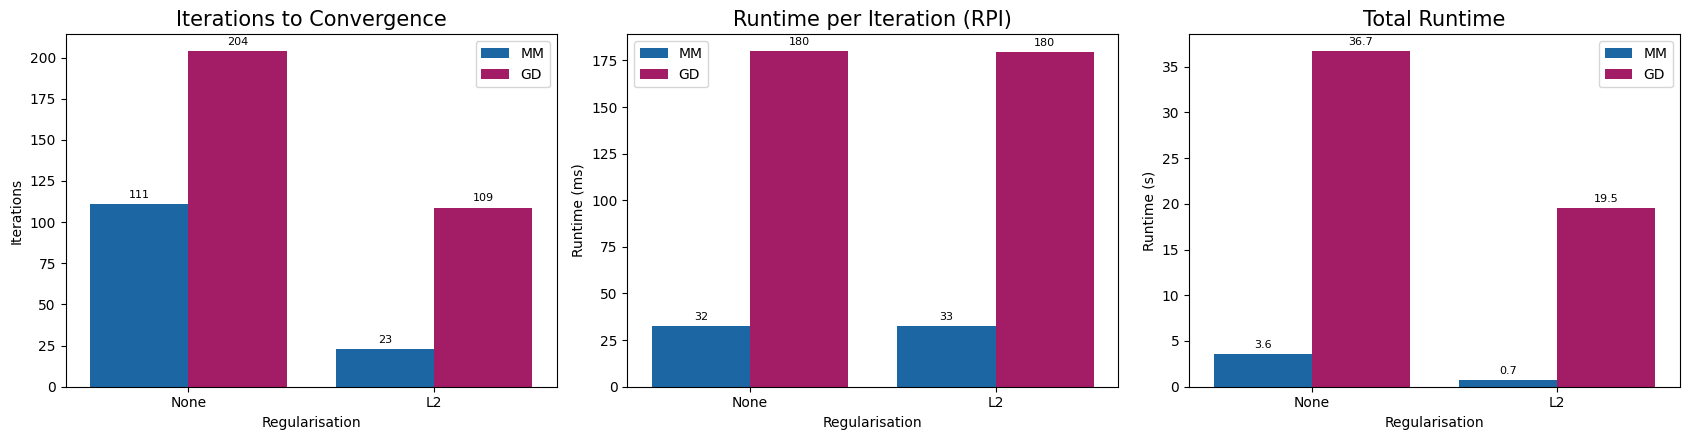

In [ ]:
save_plot3_as = None #'iters-rpi-time-bar-loan'

plot_iters_rpi_time_bar(
    main_results_df,
    dataset_name="Loan Data (n=63744, p=78)",
    optimisers=['Majorization-Minimization', 'Gradient Descent'], #'Newton-Raphson'],
    reg_types=['None', 'L2'],
    save_plot_as=save_plot3_as
)

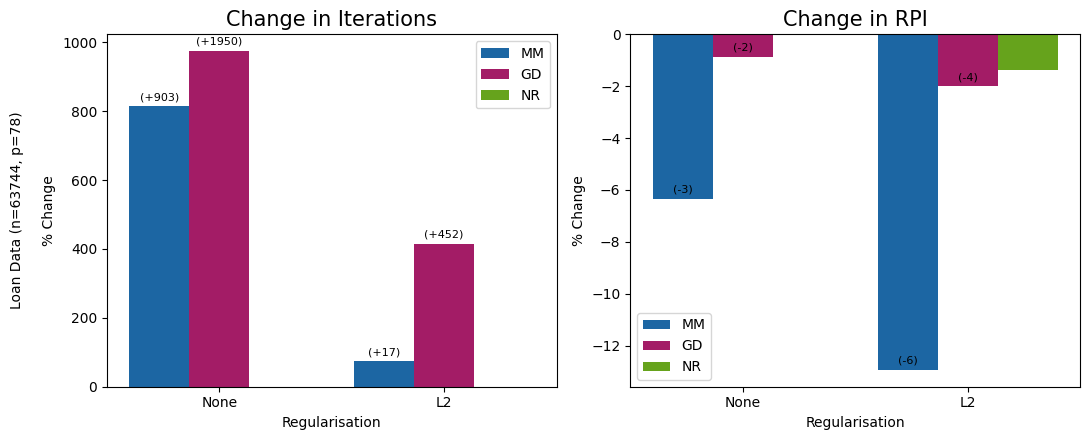

In [ ]:
save_plot4_as = None #'change-iters-and-rpi-loan'

plot_change_iters_and_rpi_bar("loan", save_plot_as=save_plot4_as)

### Results Analysis (Synthetic)

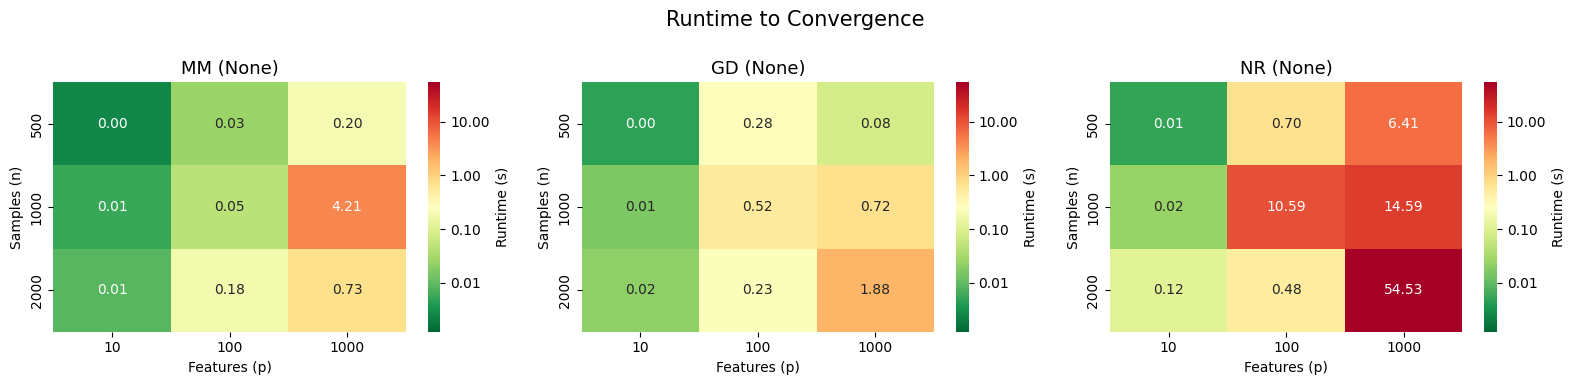

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


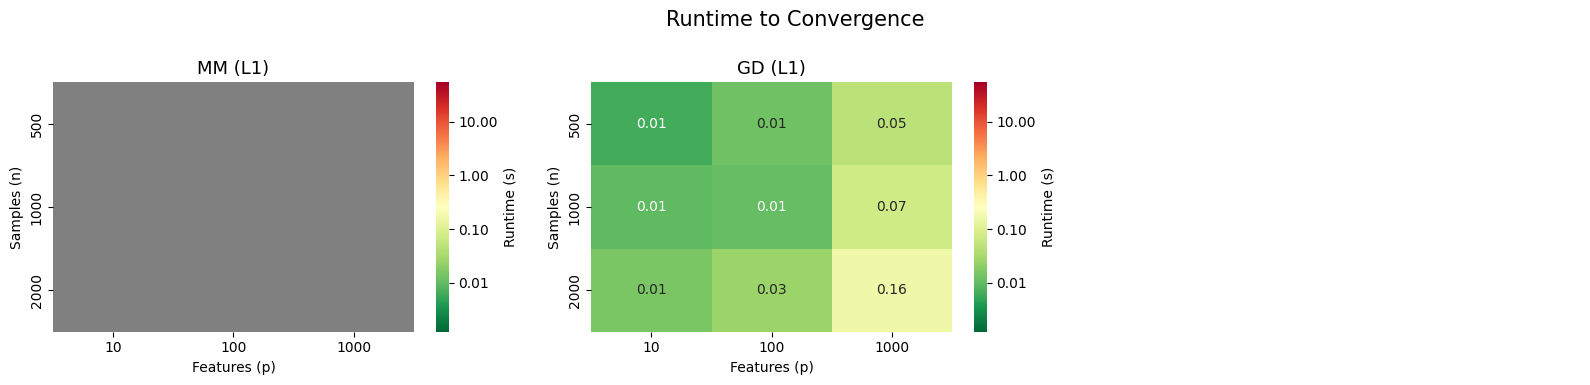

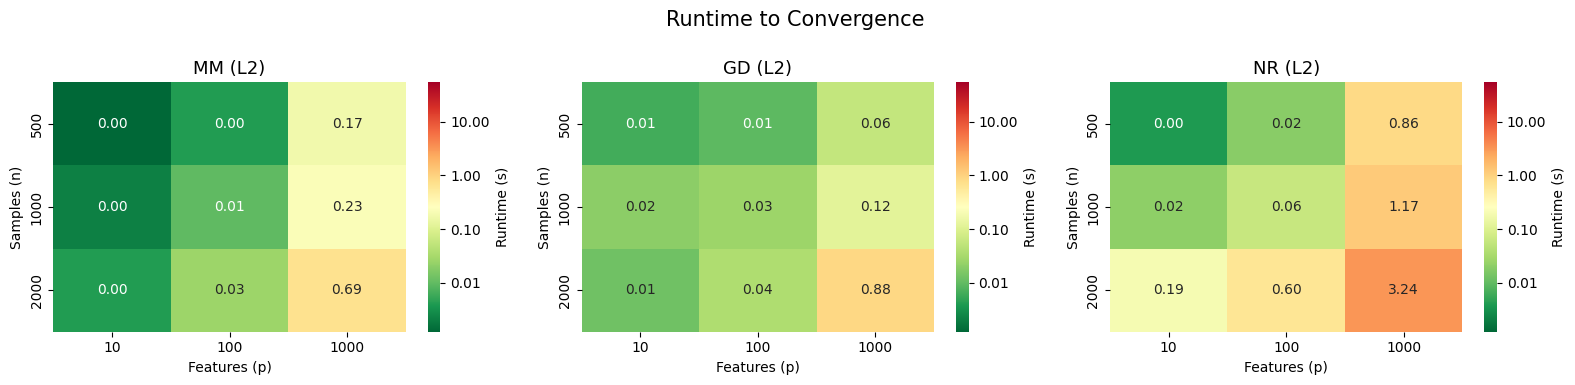

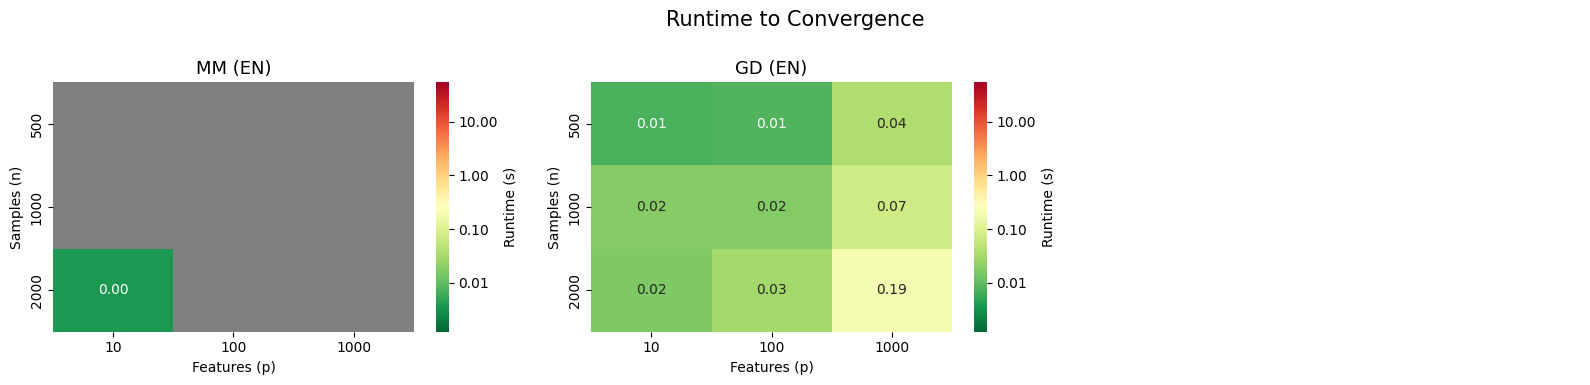

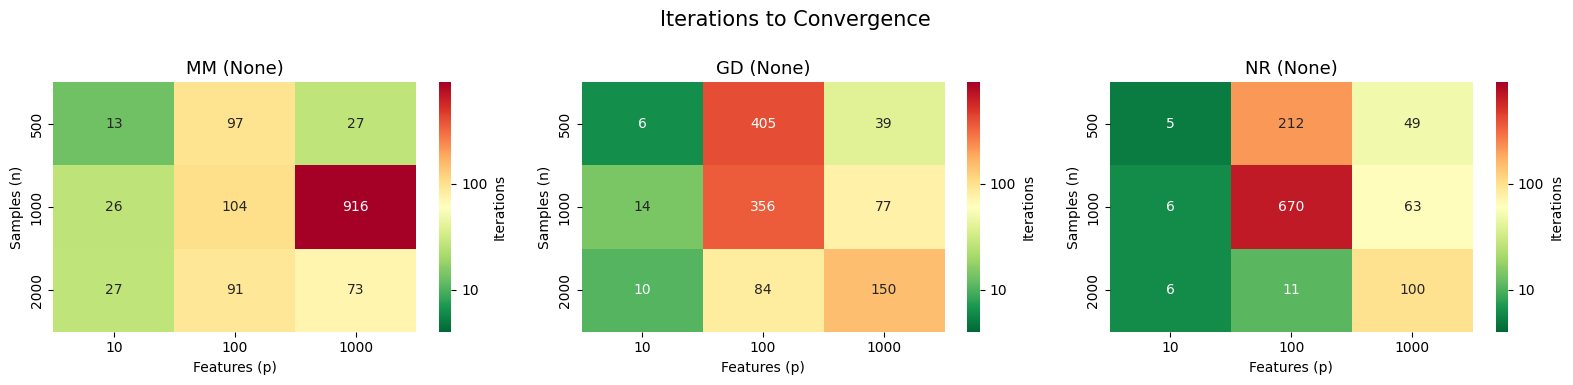

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


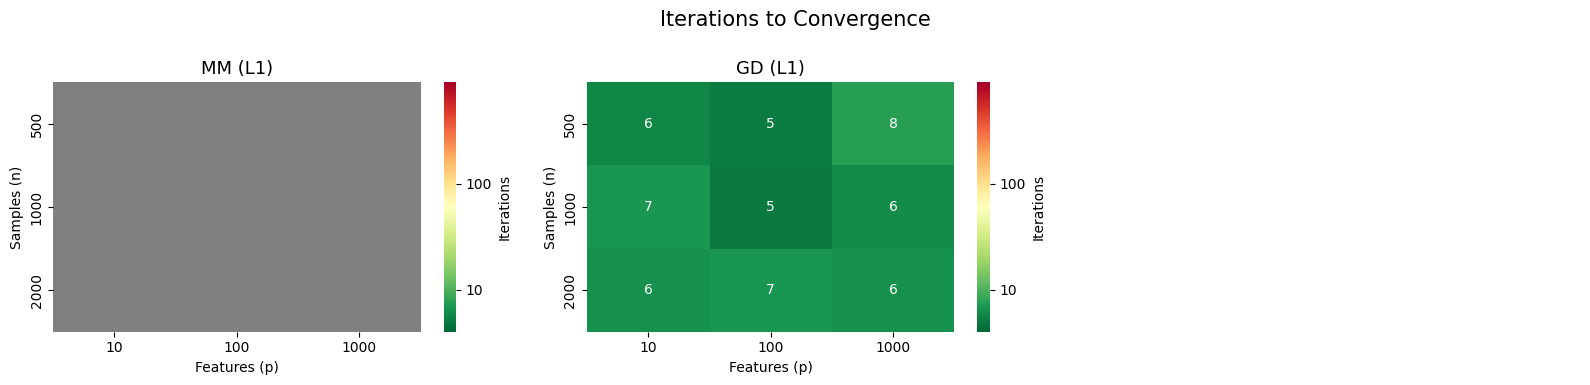

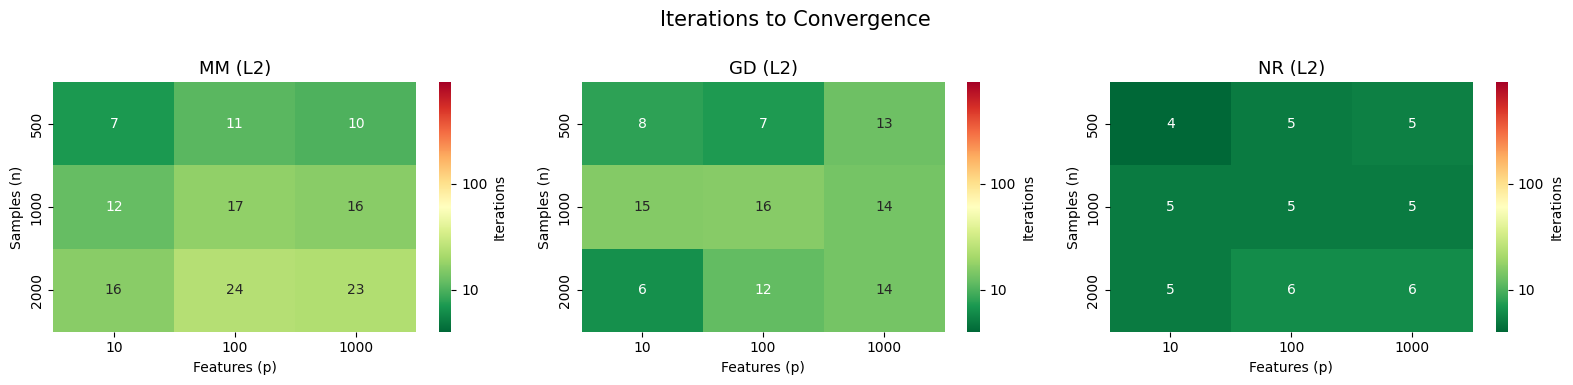

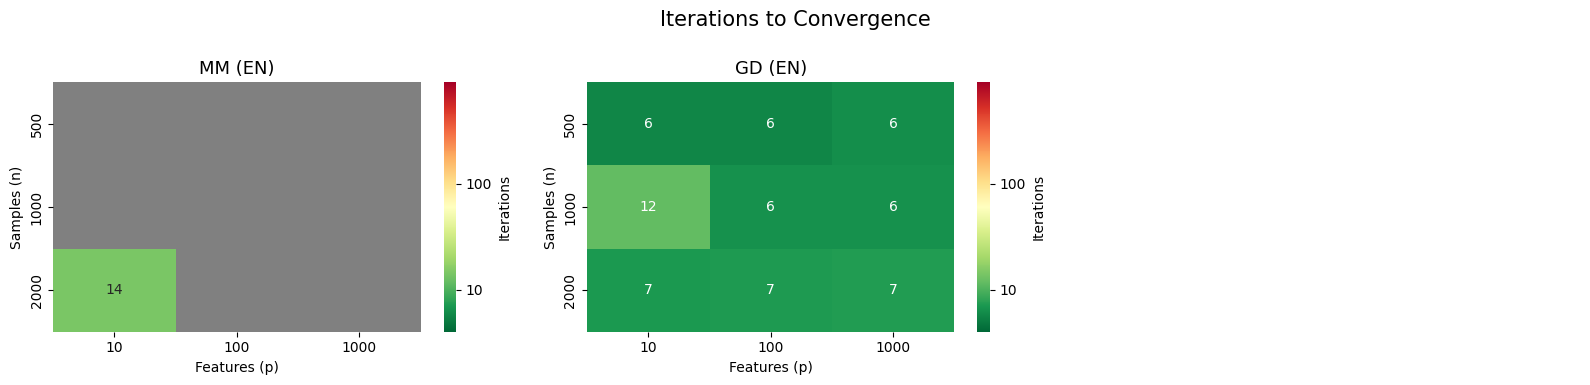

In [ ]:
save_plot5_as = None #'time-heat-syn'
save_plot6_as = None #'iter-heat-syn'

def plot_metric_heat(df, metric, save_plot_as):
    allowed = [(500,10),(500,100),(500,1000),(1000,10),(1000,100),(1000,1000),(2000,10),(2000,100),(2000,1000)]
    df = df.copy()
    df['n'], df['p'] = zip(*df['Dataset'].apply(lambda s: tuple(map(int, re.findall(r"\d+", s)))))
    df = df[df[['n', 'p']].apply(tuple, axis=1).isin(allowed)]

    is_iters = 'Iters' in metric
    label = "Iterations" if is_iters else "Runtime (s)"
    title = "Iterations to Convergence" if metric == 'Avg_Iters' else "Runtime to Convergence"
    ticks = np.log10([10,100]) if is_iters else np.log10([0.01,0.1,1,10])
    tick_labels = [str(int(10**x)) if is_iters else f"{10**x:.2f}" for x in ticks]

    v = df[metric].dropna()
    norm = Normalize(vmin=np.log10(max(v.min(),1e-4)), vmax=np.log10(v.max()))

    for reg in df['Reg'].unique():
        fig, axes = plt.subplots(1,3,figsize=(16,4))
        fig.suptitle(title, fontsize=title_font, y=0.95)

        for i, method in enumerate(df['Optimiser'].unique()):
            ax = axes[i]
            sub = df[(df['Reg']==reg)&(df['Optimiser']==method)]
            if sub.empty: ax.axis('off'); continue

            pivot = sub.pivot(index='n', columns='p', values=metric)
            mask = pivot.isna()
            data = np.log10(pivot)

            cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
            cmap.set_bad("grey")

            sns.heatmap(data, annot=pivot.round(0 if is_iters else 2),
                        fmt=".0f" if is_iters else ".2f",
                        cmap=cmap, norm=norm, mask=mask, ax=ax,
                        cbar_kws={"label": label})

            ax.set_title(f"{optimiser_labels.get(method, method)} ({reg})", fontsize=subtitle_font + 3)
            ax.set_xlabel("Features (p)", fontsize=subtitle_font)
            ax.set_ylabel("Samples (n)", fontsize=subtitle_font)
            ax.tick_params(labelsize=subtitle_font)

            cb = ax.collections[0].colorbar
            cb.set_ticks(ticks)
            cb.ax.yaxis.set_major_formatter(ticker.FixedFormatter(tick_labels))

        plt.tight_layout(rect=[0,0,1,0.95])

        if save_plot_as is not None:
            plt.savefig(f"{OUTPUT_PATH}/{save_plot_as}-{reg}.png", dpi=300)

        plt.show()
        plt.close(fig)
plot_metric_heat(main_results_df, metric='Avg_Time', save_plot_as=save_plot5_as)
plot_metric_heat(main_results_df, metric='Avg_Iters', save_plot_as=save_plot6_as)

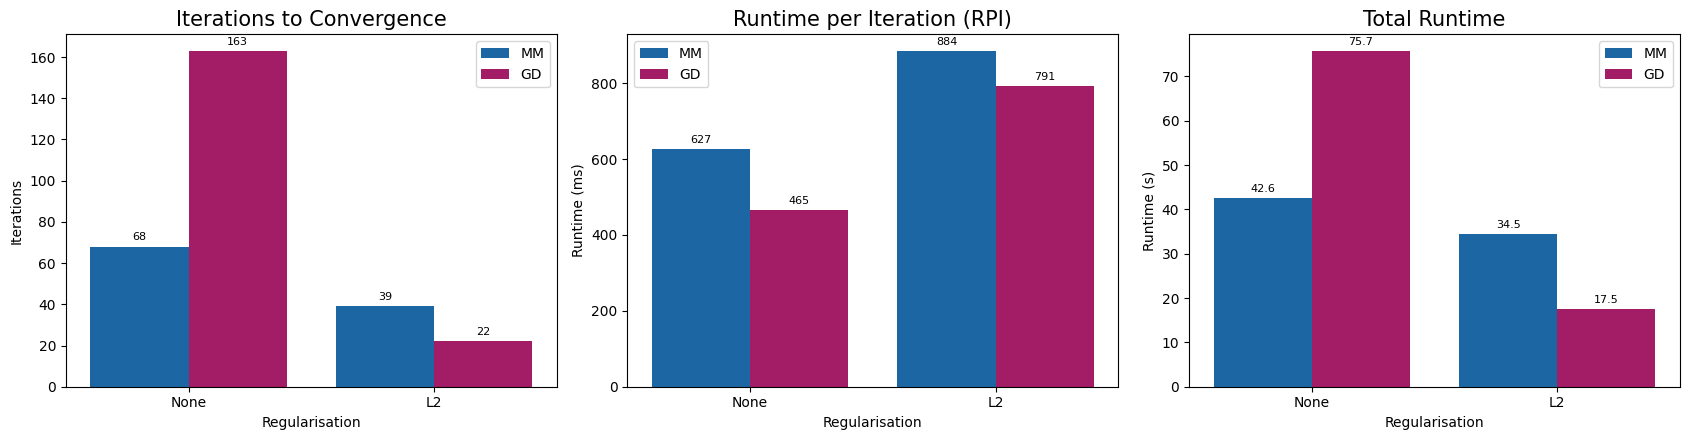

In [ ]:
save_plot7_as = None #'iters-rpi-time-bar-syn'

plot_iters_rpi_time_bar(
    main_results_df,
    dataset_name="Synthetic Data (n=10000, p=5000)",
    optimisers=['Majorization-Minimization', 'Gradient Descent'], #'Newton-Raphson'],
    reg_types=['None', 'L2'],
    save_plot_as=save_plot7_as
)

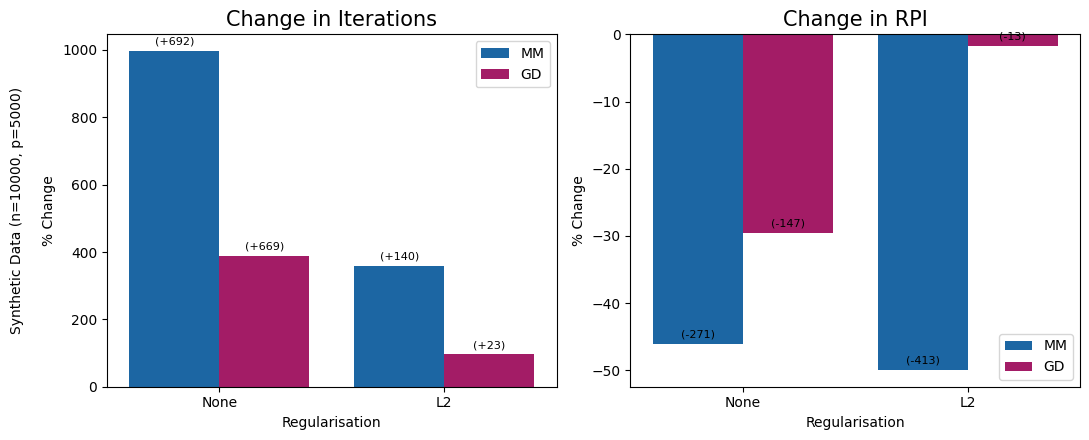

In [ ]:
save_plot8_as = None #'change-iters-and-rpi-syn'

plot_change_iters_and_rpi_bar('syn-v2', save_plot8_as)